Analysis of whether gem value (the stored fitness boost) corresponds to actual fitness boost after application.

In [2]:
import os
import pickle
from itertools import product

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from pycgp import probabilistic_mutation, point_mutation, single_mutation
from pycgp.gems import MatchByActiveStrategy, MatchSMStrategy, MatchPMStrategy

In [3]:
class DataIterator():
    def __init__(self, folder):
        self.mutations = [
          #  (probabilistic_mutation, MatchSMStrategy),
            (point_mutation, MatchPMStrategy),
            (single_mutation, MatchSMStrategy),
            (single_mutation, MatchByActiveStrategy),
            (probabilistic_mutation, MatchByActiveStrategy)
        ]
        self.gems = [5, 10]
        
        self.cols = [10, 50, 100]
        
        data = []
        for m,s,g,c,dd in self.__iterate_folder(folder):
            data.append([m, s, g, c, [x['ga_values'] for x in dd]])
        data = pd.DataFrame(data)
        data.columns = ['m', 's', 'g', 'c', 'gem_data']
        self.data = data      
    
    def __iterate_folder(self,folder):
        for index, ((mutation, strategy), gem, column) in enumerate(product(self.mutations, self.gems, self.cols)):
            file = os.path.join(folder,  f'{mutation.__name__}-{strategy.__name__}-gems{gem}-n_cols{column}.csv')
            with open (file, 'rb') as fp:
                data = pickle.load(fp)

                yield mutation.__name__, strategy.__name__, gem, column, data
    
    def iterate_gem_data(self, mutation, strategy, axis=False):
        gdatas = self.data[(self.data.m == mutation) & (self.data.s == strategy) & (self.data.g != 0)]

        if axis:
            _, axs = plt.subplots(2, len(gdatas)//2, figsize=(8,6))

        for i, (_, gdata) in enumerate(gdatas.iterrows()):
            pgdata = []
            #pdb.set_trace()
            for gem in [item for sublist in gdata.gem_data for item in sublist]:
                row = [gdata.g, gdata.c, gem[0], gem[1], gem[2]]
                pgdata.append(row)

            pgdata = pd.DataFrame(pgdata)
            pgdata.columns = ['gems', 'columns', 'stored_value', 'new_value', 'old_value']
            pgdata['gain'] = pgdata['old_value'] - pgdata['new_value']
            
            if axis:
                yield pgdata, axs[i//3][i%3]
            else:
                yield pgdata, None
    
    def stats(self):
        frames = []
        for m, s in self.mutations:
            for pgdata, _ in self.iterate_gem_data(m.__name__, s.__name__):
                pgdata['m'] = m.__name__
                pgdata['s'] = s.__name__
                frames.append(pgdata)
        data = pd.concat(frames)
        return data

import pdb
            

symreg = DataIterator('scripts/symbolic_basic/')


In [56]:
d = symreg.stats()
print(d.shape)
print(d[d.actual_value != 0].shape)


(91482, 8)
(40936, 8)


In [60]:
from scipy.stats import mstats

def plot_dists(di, limits, callback):
    data = di.stats()

    _, axs = plt.subplots(1, len(di.mutations), figsize=(16,4))

    for ax, (m,s) in zip(axs, di.mutations):
        d = data[(data.m == m.__name__) & (data.s == s.__name__) & (data.actual_value != 0) ]

        sns.distplot(mstats.winsorize(d.actual_value, limits=limits), ax=ax)
        
        ax.set_title(f'{m.__name__}\n{s.__name__}')




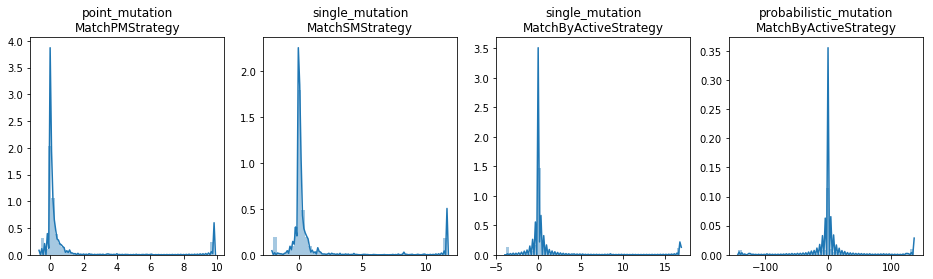

In [61]:
plot_dists(symreg, 0.05)

In [36]:
bincls = DataIterator('scripts/bin_class_out/')

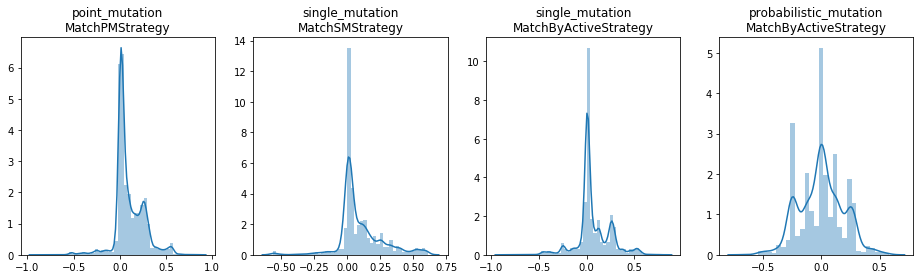

In [62]:
plot_dists(bincls, 0.00)

In [38]:
santaf = DataIterator('scripts/santa_fe_out/')

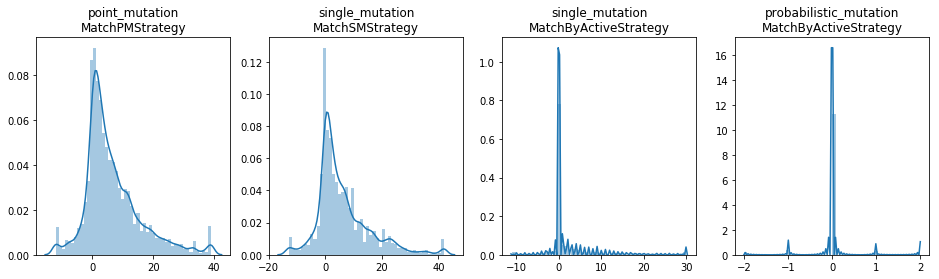

In [41]:
plot_dists(santaf, 0.01)

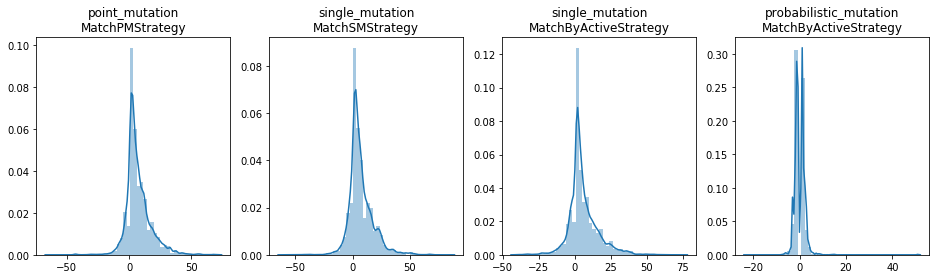

In [64]:
plot_dists(santaf, 0.00)

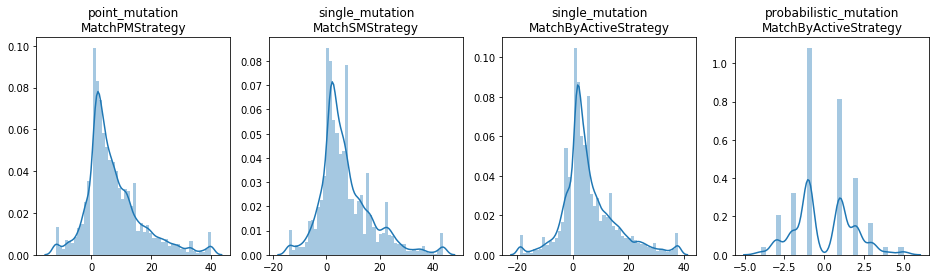

In [65]:
plot_dists(santaf, 0.01)

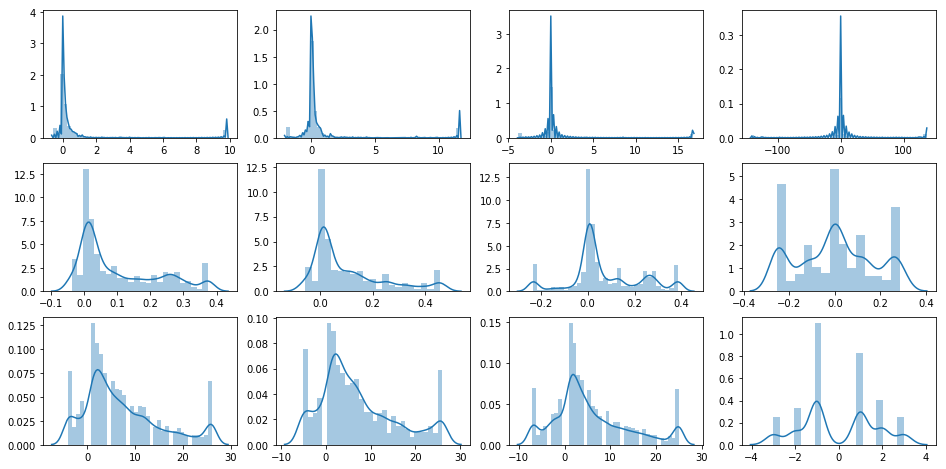

In [117]:
from sklearn.preprocessing import MinMaxScaler

_, axes = plt.subplots(3, len(symreg.mutations), figsize=(16,8))

for axs, di in zip(axes, [symreg, bincls, santaf]):
    for ax, (m,s) in zip(axs, di.mutations):
        data = di.stats()
        
        d = data[(data.m == m.__name__) & (data.s == s.__name__) & (data.actual_value != 0) ]
        
        trimmed = d.actual_value
        trimmed = mstats.winsorize(trimmed, limits=0.05)
        
        #trimmed = d.actual_value.values.reshape(-1,1)

        #sc = MinMaxScaler((-1, 1))
        
        #scaled = sc.fit_transform(trimmed.reshape(-1,1))
        #scaled = trimmed

        sns.distplot(trimmed, ax=ax)
    